### Approach1 -> Audio Processing -> XGboost and MLP Head

In [198]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import torchaudio
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import AdamW
from torch.utils.data import DataLoader, TensorDataset,Dataset
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
from transformers import Wav2Vec2Processor, Wav2Vec2Model, BertTokenizer, BertModel, AutoModel, AutoTokenizer, AutoFeatureExtractor
from xgboost import XGBRegressor
from scipy.stats import uniform, randint
import librosa
import whisper


In [180]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MODEL_NAME = "facebook/wav2vec2-base-960h"
SAMPLE_RATE = 16000
TRAIN_AUDIO_DIR = "dataset_shl/dataset/audios_train"
TEST_AUDIO_DIR =  "dataset_shl/dataset/audios_test"
TRAIN_CSV_PATH =  "dataset_shl/dataset/train.csv"
TEST_CSV_PATH =   "dataset_shl/dataset/test.csv"
df_train = pd.read_csv(TRAIN_CSV_PATH)
df_test  = pd.read_csv(TEST_CSV_PATH)

In [123]:
processor = Wav2Vec2Processor.from_pretrained(MODEL_NAME)
wav2vec_model = Wav2Vec2Model.from_pretrained(MODEL_NAME).to(DEVICE).eval()

Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [129]:
def extract_features(audio_path):
    waveform, sr = librosa.load(audio_path , sr = SAMPLE_RATE)
    waveform = torch.tensor(waveform).unsqueeze(0)  # shape: [1, num_samples]

    input_values = processor(
        waveform.squeeze(), 
        sampling_rate=SAMPLE_RATE, 
        return_tensors="pt"
    ).input_values.to(DEVICE)
    
    with torch.no_grad():
        outputs = wav2vec_model(input_values)
        hidden_states = outputs.last_hidden_state

    pooled = hidden_states.mean(dim=1).squeeze().cpu().numpy()
    return pooled

In [130]:
# Extracting Training Dataset Features 
features = []
labels = []

print("Extracting Training dataset features...")
for i, row in tqdm(df_train.iterrows(), total=len(df_train)):
    file_path = f"{TRAIN_AUDIO_DIR}/{row['filename']}"
    try:
        feat = extract_features(file_path)
        features.append(feat)
        labels.append(row["label"])
    except Exception as e:
        print(f"Error processing {file_path}: {e}")

X = np.stack(features)
y = np.array(labels)

Extracting Training dataset features...


100%|████████████████████████████████████████████████████████████████████████████████| 444/444 [17:09<00:00,  2.32s/it]


In [131]:
len(df_test)

195

In [108]:
# Extracting Test Dataset Features 

features = []
print("Extracting TEST dataset features...")
for i, row in tqdm(df_test.iterrows(), total=len(df_test)):
    file_path = os.path.join(TEST_AUDIO_DIR, row["filename"])
    try:
        feat = extract_features(file_path)
        features.append(feat)
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        
X_test = np.stack(features)


Extracting TEST dataset features...


100%|██████████| 195/195 [01:03<00:00,  3.08it/s]


In [109]:
X_test.shape

(195, 768)

## XGBOOST regressor


In [135]:
# Define the model
xgb = XGBRegressor(random_state=42, n_jobs=-1)

# Define hyperparameter space
param_dist = {
    'n_estimators': randint(100, 500),
    'learning_rate': uniform(0.01, 0.3),
    'max_depth': randint(3, 10),
    'subsample': uniform(0.6, 0.4),
    'colsample_bytree': uniform(0.6, 0.4),
    'gamma': uniform(0, 5),
    'reg_alpha': uniform(0, 1),
    'reg_lambda': uniform(0, 1),
}

# Perform Randomized Search with 5-fold CV
random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=50,
    scoring='neg_mean_squared_error',  # or use 'r2' for R2 score
    cv=5,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
# Fit the model
random_search.fit(X_train, y_train)

# Best model after tuning
best_model = random_search.best_estimator_ 

Fitting 5 folds for each of 50 candidates, totalling 250 fits


In [142]:
# Evaluate on validation set
val_preds = best_model.predict(X_val)
val_score = root_mean_squared_error(y_val, val_preds)  # RMSE

print("Best Hyperparameters:", random_search.best_params_)
print("Validation RMSE:", val_score)
torch.save(model.state_dict(), f"best_model_xgboost.pt")

Best Hyperparameters: {'colsample_bytree': np.float64(0.8976170571996461), 'gamma': np.float64(1.254302636733306), 'learning_rate': np.float64(0.06530010229941101), 'max_depth': 8, 'n_estimators': 378, 'reg_alpha': np.float64(0.42831447494010777), 'reg_lambda': np.float64(0.6884999007653664), 'subsample': np.float64(0.6232774382033774)}
Validation RMSE: 0.9045103837662085


In [47]:
test_preds = model_1.predict(X_test)
df_test_preds = pd.DataFrame()
df_test_preds["filename"] = df_test['filename']
df_test_preds['label'] = test_preds

df_test_preds.head()


,filename,label
0,audio_706.wav,2.264599
1,audio_800.wav,3.339555
2,audio_68.wav,3.814336
3,audio_1267.wav,3.140778
4,audio_683.wav,2.583885


In [48]:
df_test_preds.to_csv("sub.csv",index = False)

## DEEP MLP REGRESSOR

In [145]:
class MLPRegressor(nn.Module):
    def __init__(self, input_dim):
        super(MLPRegressor, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.4),

            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(128, 64),
            nn.ReLU(),

            nn.Linear(64, 1)  # Final regression output
        )

    def forward(self, x):
        return self.model(x)

In [150]:

def train_model(model, X_train, y_train, X_val, y_val, epochs=500, batch_size=32, lr=1e-4, patience=5):
    # Prepare data
    train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32),
                                  torch.tensor(y_train, dtype=torch.float32).unsqueeze(1))
    val_dataset = TensorDataset(torch.tensor(X_val, dtype=torch.float32),
                                torch.tensor(y_val, dtype=torch.float32).unsqueeze(1))

    train_loader = DataLoader(train_dataset,
                              batch_size=batch_size,
                              shuffle=True)
    val_loader = DataLoader(val_dataset,
                            batch_size=batch_size)

    # Loss & optimizer
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(epochs):
        model.train()
        train_losses = []

        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(DEVICE), y_batch.to(DEVICE)

            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

            train_losses.append(loss.item())

        # Validation phase
        model.eval()
        val_losses = []
        preds = []
        actuals = []

        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(DEVICE), y_batch.to(DEVICE)
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                val_losses.append(loss.item())

                preds.extend(outputs.squeeze().cpu().numpy())
                actuals.extend(y_batch.squeeze().cpu().numpy())

        avg_train_loss = sum(train_losses) / len(train_losses)
        avg_val_loss = sum(val_losses) / len(val_losses)
        rmse = np.sqrt(mean_squared_error(actuals, preds))
        if((epoch+1)%10 == 0):
            print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val RMSE: {rmse:.4f}")

        # Early stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            torch.save(model.state_dict(), "best_model_Bert_plus_MLP.pt")  # Save best model
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping!")
                break

    # Load best model before returning
    model.load_state_dict(torch.load("best_model_Bert_plus_MLP.pt"))
    return model

In [151]:
model = MLPRegressor(input_dim=X_train.shape[1]).to(DEVICE)
trained_model = train_model(model, X_train, y_train, X_val, y_val)

Epoch 10/500 | Train Loss: 5.6875 | Val Loss: 7.2051 | Val RMSE: 2.6986
Epoch 20/500 | Train Loss: 1.2488 | Val Loss: 2.1421 | Val RMSE: 1.4854
Epoch 30/500 | Train Loss: 0.7752 | Val Loss: 1.3711 | Val RMSE: 1.1871
Epoch 40/500 | Train Loss: 0.7362 | Val Loss: 1.2589 | Val RMSE: 1.1335
Epoch 50/500 | Train Loss: 0.6708 | Val Loss: 1.3590 | Val RMSE: 1.1740
Early stopping!


C:\Users\syedd\AppData\Local\Temp\ipykernel_75124\2495675284.py:70: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model_Bert_plus_MLP.

In [152]:
def predict(model, X_test, batch_size=32):
    model.eval()
    test_dataset = torch.tensor(X_test, dtype=torch.float32)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)
    predictions = []
    with torch.no_grad():
        for X_batch in test_loader:
            X_batch = X_batch.to(DEVICE)
            outputs = model(X_batch)
            predictions.extend(outputs.squeeze().cpu().numpy())

    return predictions

In [38]:
# Predict on X_test
test_preds = predict(trained_model, X_test)

# Create submission file (example)
df_test_preds = pd.DataFrame({
    "filename": df_test["filename"],  # Make sure df_test has this column
    "label": test_preds
})

# Save to CSV
df_test_preds.to_csv("submission2.csv", index=False)

## Approach 2 -> Consider Audio Waveform as input.

In [184]:
model_whisper = whisper.load_model("base")
model_whisper = model_whisper.to(DEVICE)
def transcribe_audio(file_path):
    try:
        result = model_whisper.to(DEVICE).transcribe(file_path)
        return result["text"]
    except Exception as e:
        print(f"Error transcribing {file_path}: {e}")
        return ""

C:\Users\syedd\miniconda3\envs\hmenv3\Lib\site-packages\whisper\__init__.py:150: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(fp, map_location=devic

In [187]:
file_path = f'{TRAIN_AUDIO_DIR}/{df_train.iloc[20]["filename"]}'
transcript = transcribe_audio(file_path)

#### # Pre_Extract the transcripts and save them.


In [188]:
transcripts_train = []
print("Extracting Train dataset Transcripts...")
for i, row in tqdm(df_train.iterrows(), total=len(df_train)):
    file_path = f'{TRAIN_AUDIO_DIR}/{row["filename"]}'
    try:
        transcript = transcribe_audio(file_path, DEVICE)
        transcripts_train.append(transcript)
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        


In [189]:
df_test = pd.read_csv(TEST_CSV_PATH)
transcripts_test = []
print("Extracting Train dataset Transcripts...")
for i, row in tqdm(df_test.iterrows(), total=len(df_test)):
    file_path = os.path.join(TEST_AUDIO_DIR, row["filename"])
    try:
        transcript = transcribe_audio(file_path,DEVICE)
        transcripts.append(transcript)
    except Exception as e:
        print(f"Error processing {file_path}: {e}")

In [ ]:
df_train_transcript = pd.DataFrame() 
df_train_transcript['text'] = transcripts_train
df_train_transcript['label'] = df_train['label']
df_train_transcript['filename'] = df_train['filename']
df_train_transcript.head()


In [ ]:
df_test_transcript = pd.DataFrame() 
df_test_transcript['text'] = transcripts
df_test_transcript['filename'] = df_test['filename']
df_test_transcript.head()

In [ ]:
df_train_transcript.to_csv("train_transcript.csv",index = False)
df_test_transcript.to_csv("test_transcript.csv",index = False)

#### Transcripted Dataset Class

In [191]:
class TranscriptDataset(Dataset):
    def __init__(self , df , tokenizer,max_len = 128,training = True):
        self.texts = df["text"].tolist()
        self.texts = [str(t) if pd.notna(t) else "" for t in self.texts]  # Ensures string input

        if training:
            self.labels = df["label"].tolist()
        self.tokenizer= tokenizer
        self.max_len = max_len
        self.training = training

    def __len__(self):
        return len(self.texts)

    def __getitem__(self,idx):
        encodings = self.tokenizer(
            self.texts[idx],
            truncation=True,
            padding='max_length',
            max_length=self.max_len,
            return_tensors="pt"
        )
        input_ids = encodings["input_ids"].squeeze(0)
        attention_mask = encodings["attention_mask"].squeeze(0)
        if (self.training == True):
            label = torch.tensor(self.labels[idx], dtype=torch.float)

            return {
            "input_ids": input_ids,
            "attention_mask": attention_mask,
            "label": label
            }
        else:
            return {
            "input_ids": input_ids,
            "attention_mask": attention_mask
            }
            

In [192]:
class BERTRegression(nn.Module):
    def __init__(self, dropout=0.3):
        super().__init__()
        self.bert = BertModel.from_pretrained("bert-base-uncased")
        self.regressor = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(self.bert.config.hidden_size, 256),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled = outputs.pooler_output  # [CLS] token representation
        raw_output = self.regressor(pooled).squeeze(1)
        scaled_output = 5 * torch.sigmoid(raw_output)  # Constrain to [0, 5]
        return scaled_output

In [193]:
def train_epoch(model, loader, optimizer, criterion):
    model.train()
    total_loss = 0
    for batch in (loader):
        input_ids = batch["input_ids"].to(DEVICE)
        attention_mask = batch["attention_mask"].to(DEVICE)
        labels = batch["label"].to(DEVICE)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    return total_loss / len(loader)

def eval_epoch(model, loader, criterion):
    model.eval()
    total_loss = 0
    preds, actuals = [], []
    with torch.no_grad():
        for batch in (loader):
            input_ids = batch["input_ids"].to(DEVICE)
            attention_mask = batch["attention_mask"].to(DEVICE)
            labels = batch["label"].to(DEVICE)

            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            preds.extend(outputs.cpu().numpy())
            actuals.extend(labels.cpu().numpy())
    return total_loss / len(loader), preds, actuals

In [199]:
# Model, Loss, Optimizer
model = BERTRegression(dropout = 0.4).to(DEVICE)
criterion = nn.MSELoss()
optimizer = AdamW(model.parameters(), lr=2e-5)
BATCH_SIZE = 16


In [194]:
# Load data
df_train_transcript = pd.read_csv("dataset_shl/dataset/train_transcript.csv")
train_df, val_df = train_test_split(df_train_transcript, test_size=0.2, random_state=42)

# Tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Dataset & DataLoader
train_dataset = TranscriptDataset(train_df, tokenizer)
val_dataset = TranscriptDataset(val_df, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)


In [196]:
# Training Loop
epochs = 100
best_val_loss = float('inf')
for epoch in tqdm(range(epochs)):
    train_loss = train_epoch(model, train_loader, optimizer, criterion)
    val_loss, preds, labels = eval_epoch(model, val_loader, criterion)
    if (val_loss < best_val_loss):
        torch.save(model.state_dict(), "bert_MLP_regressor.pt")
        best_val_loss = val_loss
    if((epoch+1)%10==0):
        print(f"Epoch {epoch+1} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

 10%|████████                                                                         | 10/100 [04:39<41:49, 27.89s/it]

Epoch 10 | Train Loss: 0.2371 | Val Loss: 0.6382


 20%|████████████████▏                                                                | 20/100 [09:17<37:02, 27.78s/it]

Epoch 20 | Train Loss: 0.1315 | Val Loss: 0.7304


 30%|████████████████████████▎                                                        | 30/100 [13:54<32:23, 27.76s/it]

Epoch 30 | Train Loss: 0.0588 | Val Loss: 0.7193


 40%|████████████████████████████████▍                                                | 40/100 [18:32<27:44, 27.75s/it]

Epoch 40 | Train Loss: 0.0515 | Val Loss: 0.7778


 47%|██████████████████████████████████████                                           | 47/100 [21:50<24:38, 27.89s/it]


KeyboardInterrupt: 

In [200]:
df_test_transcript = pd.read_csv("dataset_shl/dataset/test_transcript.csv")
test_dataset = TranscriptDataset(df_test_transcript, tokenizer, training = False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [201]:
def predict(model, test_loader):
    model.eval()
    predictions = []
    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Predicting"):
            input_ids = batch['input_ids'].to(DEVICE)
            attention_mask = batch['attention_mask'].to(DEVICE)
            outputs = model(input_ids, attention_mask)
            predictions.extend(outputs.cpu().numpy())

    return predictions


In [202]:
model.load_state_dict(torch.load("bert_MLP_regressor.pt"))
predictions = predict(model, test_loader)

C:\Users\syedd\AppData\Local\Temp\ipykernel_75124\4055783567.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("bert_MLP_regressor.pt"))
P

In [203]:
len(predictions)

195

In [204]:
sub_df = pd.DataFrame()
sub_df['filename'] = df_test['filename']
sub_df['label'] = predictions
sub_df.to_csv("sub3.csv",index = False)
sub_df.head()

,filename,label
0,audio_706.wav,4.486119
1,audio_800.wav,2.264364
2,audio_68.wav,3.921659
3,audio_1267.wav,2.468159
4,audio_683.wav,2.256742


### Approach -> Weighted merge of different approaches

In [ ]:
def weighted_merge(df1, df2, alpha=0.5):
    # Ensure filenames match and merge
    merged = pd.merge(df1, df2, on='filename', how='inner', suffixes=('_1', '_2'))

    # Compute weighted sum of scores
    merged['label'] = alpha * merged['label_1'] + (1-alpha) * merged['label_2']

    # Return only required columns
    return merged[['filename', 'label']].reset_index(drop=True)

In [58]:
sub_df_prev = pd.read_csv("submission2.csv")
sub_df4 = weighted_merge(sub_df,sub_df_prev)
sub_df4.to_csv("sub4.csv",index = False)
sub_df4.head()

,filename,label
0,audio_706.wav,3.112394
1,audio_800.wav,2.808166
2,audio_68.wav,3.912927
3,audio_1267.wav,2.910975
4,audio_683.wav,2.511891


## Approach ->  Synthetic data merged traininig

In [29]:
df_train_transcript = pd.read_csv("/kaggle/input/test-and-train-kaggle-dataset-transcripts/train_transcript.csv")
synthetic_data_df = pd.read_csv("dataset_shl/dataset/synthetic_transcript_dataset_2.csv")
synthetic_data_df.head()


,text,label
0,My family go to beach last weekend. My family ...,3.37
1,He is very like play game. I go market buy fru...,1.71
2,He likes to playing football in evening.,3.56
3,He is very like play game.,1.46
4,I go market buy fruit. No good shop. He is ver...,1.20


In [30]:
concatenated_df = pd.concat([synthetic_data_df, df_train_transcript], ignore_index=True)
print(len(concatenated_df))
concatenated_df.head()

1444


,text,label
0,My family go to beach last weekend. My family ...,3.37
1,He is very like play game. I go market buy fru...,1.71
2,He likes to playing football in evening.,3.56
3,He is very like play game.,1.46
4,I go market buy fruit. No good shop. He is ver...,1.20


In [32]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load data
concatenated_df = concatenated_df.sample(frac=1, random_state=42).reset_index(drop=True)
train_df, val_df = train_test_split(concatenated_df, test_size=0.2, random_state=42)

# Tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Dataset & DataLoader
train_dataset = TranscriptDataset(train_df, tokenizer)
val_dataset = TranscriptDataset(val_df, tokenizer)

train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size = BATCH_SIZE)


In [40]:
# Model, Loss, Optimizer
model = BERTRegression(dropout = 0.4).to(DEVICE)
criterion = nn.MSELoss()
optimizer = AdamW(model.parameters(), lr=2e-5)

In [43]:
# Training Loop
epochs = 50
patience_counter = 0
best_val_loss = 1000000
patience = 10

for epoch in tqdm(range(epochs)):
    train_loss = train_epoch(model, train_loader, optimizer, criterion)
    avg_val_loss, preds, labels = eval_epoch(model, val_loader, criterion)
    if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            torch.save(model.state_dict(), "best_model_with_synthetic_transcript.pt")  # Save best model
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping!")
            break

    if((epoch+1)%5==0):
        print(f"Epoch {epoch+1} | Train Loss: {train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

 10%|█         | 5/50 [02:42<24:23, 32.52s/it]

Epoch 5 | Train Loss: 0.1090 | Val Loss: 0.2603


 20%|██        | 10/50 [05:20<21:13, 31.84s/it]

Epoch 10 | Train Loss: 0.0953 | Val Loss: 0.2908


 28%|██▊       | 14/50 [07:59<20:31, 34.22s/it]

Early stopping!


In [50]:
model.load_state_dict(torch.load("best_model_with_synthetic_transcript.pt"))
predictions = predict(model, test_loader)

<ipython-input-50-2281680ae404>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model_transcript.pt"))
Predicting: 100%|██████████| 1

In [52]:
sub_df = pd.DataFrame()
sub_df['filename'] = df_test['filename']
sub_df['label'] = predictions
sub_df.to_csv("sub6.csv",index = False)
sub_df.head()

,filename,label
0,audio_706.wav,3.960189
1,audio_800.wav,2.276778
2,audio_68.wav,4.011518
3,audio_1267.wav,2.681172
4,audio_683.wav,2.439897


#### Weighted Merge

In [55]:
sub_df_prev = pd.read_csv("sub.csv")
sub_df7 = weighted_merge(sub_df,sub_df_prev)
sub_df7.to_csv("sub7.csv",index = False)
sub_df7.head()

,filename,label
0,audio_706.wav,3.112394
1,audio_800.wav,2.808166
2,audio_68.wav,3.912927
3,audio_1267.wav,2.910975
4,audio_683.wav,2.511891


## Approach -> Multimodal archtecture i.e. Use both audio and transcript features

In [210]:
df_train_kaggle = pd.read_csv("dataset_shl/dataset/train.csv")
train_transcript_data = pd.read_csv("dataset_shl/dataset/train_transcript.csv")
train_transcript_data['filename'] = df_train_kaggle['filename']
train_transcript_data.head()
# len(df_train_kaggle),len(train_transcript_data)

,text,label,filename
0,1.5% 1.5% 1.5% 1.5% 1.5% 1.5% 1.5% 1.5% 1.5% ...,1.0,audio_1261.wav
1,The playground looks like very clear and neat...,1.5,audio_942.wav
2,2011 2011 2007 nd to have a about the electro...,1.5,audio_1110.wav
3,My favorite place is in Andhra Pradesh. It is...,1.5,audio_1024.wav
4,My favorite place is UTI and PRAKAN. My exper...,2.0,audio_538.wav


In [211]:
audio_model= "facebook/wav2vec2-base-960h"
text_model =  "bert-base-uncased"
learning_rate = 2e-5
batch_size = 1
epochs = 50
audio_max_len = 16000*60
text_max_len = 128

In [212]:
class GrammarDataset(Dataset):
    def __init__(self, data, tokenizer, feature_extractor, task, audio_max_len=16000*60):
        """
        Args:
            data (DataFrame): Contains 'filename', 'text', and optionally 'label'.
            tokenizer: Hugging Face tokenizer for text.
            feature_extractor: Hugging Face feature extractor for audio.
            task (str): 'train' or other (inference/eval).
            audio_max_len (int): Max audio length in samples (default is 60s at 16kHz).
        """
        
        self.data = data #Dataframe
        self.tokenizer = tokenizer
        self.feature_extractor = feature_extractor
        self.task = task
        self.audio_max_len = audio_max_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data.iloc[idx]
        file_path = f'dataset_shl/dataset/audios_{self.task}/{item["filename"]}'
        
        # Load audio
        audio, sr = librosa.load(file_path, sr=16000)

        # Pad or truncate audio
        audio_tensor = torch.tensor(audio)
        if len(audio_tensor) < self.audio_max_len:
            pad_len = self.audio_max_len - len(audio_tensor)
            audio_tensor = F.pad(audio_tensor, (0, pad_len))
        else:
            audio_tensor = audio_tensor[:self.audio_max_len]

        # Extract audio features
        audio_features = self.feature_extractor(
            audio_tensor.numpy(),
            sampling_rate=sr,
            return_tensors="pt"
        )

        # Extract text features
        text = item.get('text', '')
        if not isinstance(text, str):
            text = ''
        text_features = self.tokenizer(
            text,
            truncation=True,
            padding="max_length",
            max_length=128,
            return_tensors="pt"
        )

        # Package features
        sample = {
            'audio_input': audio_features.input_values.squeeze(0),
            'text_input_ids': text_features.input_ids.squeeze(0),
            'text_attention_mask': text_features.attention_mask.squeeze(0)
        }

        # Add label if training
        if self.task == 'train':
            sample['label'] = torch.tensor(item['label'], dtype=torch.float)

        return sample

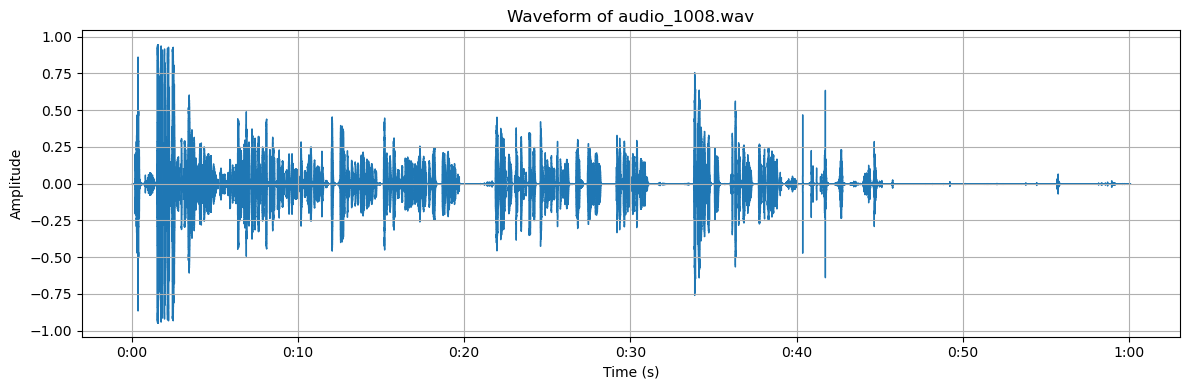

In [213]:
waveform, sample_rate = librosa.load("dataset_shl/dataset/audios_train/audio_1128.wav" , sr = 16000)
plt.figure(figsize=(12, 4))
librosa.display.waveshow(waveform, sr=16000)
plt.title("Waveform of audio_1008.wav")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.grid(True)
plt.tight_layout()
plt.show()

In [215]:
class MultimodalGrammarScorer(nn.Module):
    def __init__(self, audio_model_name, text_model_name):
        super().__init__()
        self.audio_encoder = AutoModel.from_pretrained(audio_model_name)
        self.text_encoder = AutoModel.from_pretrained(text_model_name)

        self.fc = nn.Sequential(
            nn.Linear(self.audio_encoder.config.hidden_size + self.text_encoder.config.hidden_size, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 1)
        )

    def forward(self, audio_input, text_input_ids, text_attention_mask):
        audio_embed = self.audio_encoder(audio_input).last_hidden_state[:, 0, :]  # CLS Token
        text_embed = self.text_encoder(input_ids=text_input_ids, attention_mask=text_attention_mask).last_hidden_state[:, 0, :]
        
        combined = torch.cat([audio_embed, text_embed], dim=1)
        output = self.fc(combined)
        
        return output.squeeze()

In [216]:
import gc
torch.cuda.empty_cache()
gc.collect()


9913

In [217]:
tokenizer = AutoTokenizer.from_pretrained(text_model)
feature_extractor = AutoFeatureExtractor.from_pretrained(audio_model)

# Load your train_data / val_data
train_df, val_df = train_test_split(train_transcript_data, test_size=0.2, random_state=42)

train_dataset = GrammarDataset(train_df, tokenizer, feature_extractor,task = 'train')
val_dataset = GrammarDataset(val_df, tokenizer, feature_extractor , task = 'train')

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


In [218]:
model = MultimodalGrammarScorer(audio_model, text_model).cuda()
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
loss_fn = torch.nn.MSELoss()

Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
best_rmse = float('inf')
patience = 0
patience_limit = 10
train_loss_list = []
val_loss_list = []
for epoch in range(epochs):
    model.train()
    for batch in tqdm(train_loader):
        audio_input = batch['audio_input'].cuda()
        text_input_ids = batch['text_input_ids'].cuda()
        text_attention_mask = batch['text_attention_mask'].cuda()
        scores = batch['label'].cuda()

        preds = model(audio_input, text_input_ids, text_attention_mask)
        train_loss = loss_fn(preds, scores)

        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
    model.eval()
    with torch.no_grad():
        for batch in tqdm(val_loader, desc = 'Evaluating'):
        
            audio_input = batch['audio_input'].cuda()
            text_input_ids = batch['text_input_ids'].cuda()
            text_attention_mask = batch['text_attention_mask'].cuda()
            scores = batch['label'].cuda()
    
            preds = model(audio_input, text_input_ids, text_attention_mask)
            val_loss = loss_fn(preds, scores)

    print(f"Epoch {epoch}: Train Loss : {train_loss.item()} : Val Loss : {val_loss}")

    if val_loss < best_rmse:
        patience = 0
        best_rmse = val_loss
        torch.save(model.state_dict(), f"best_model_audio_plus_text_bert_whisper.pt")
            # print(f"Saved Best Model with RMSE: {best_rmse:.4f}")
    else:
        patience = patience + 1
        if(patience > patience_limit):
            print("Early Stopping")
            break


  0%|                                                                                          | 0/355 [00:00<?, ?it/s]C:\Users\syedd\miniconda3\envs\hmenv3\Lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 89/89 [00:07<00:00, 11.14it/s]


Epoch 0: Train Loss : 0.2085830271244049 : Val Loss : 2.4994354248046875


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 89/89 [00:07<00:00, 12.05it/s]


Epoch 1: Train Loss : 3.568352222442627 : Val Loss : 0.35052555799484253


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 89/89 [00:07<00:00, 12.00it/s]


Epoch 2: Train Loss : 0.19680015742778778 : Val Loss : 0.1666007936000824


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 89/89 [00:07<00:00, 12.03it/s]


Epoch 3: Train Loss : 0.011868573725223541 : Val Loss : 0.28118637204170227


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 89/89 [00:07<00:00, 12.01it/s]


Epoch 4: Train Loss : 0.08695416152477264 : Val Loss : 0.9346666932106018


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 89/89 [00:07<00:00, 12.03it/s]


Epoch 5: Train Loss : 0.030902065336704254 : Val Loss : 0.4975524842739105


 96%|████████████████████████████████████████████████████████████████████████████▊   | 341/355 [01:32<00:03,  3.70it/s]

In [ ]:
test_dataset = GrammarDataset(test_transcript_data, tokenizer, feature_extractor,task = 'test')
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


In [ ]:
def predict(model, test_loader):
    model.eval()
    predictions = []
    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Predicting"):
            audio_input = batch['audio_input'].cuda()
            text_input_ids = batch['text_input_ids'].cuda()
            text_attention_mask = batch['text_attention_mask'].cuda()
            # scores = batch['label'].cuda()
    
            preds = model(audio_input, text_input_ids, text_attention_mask)
            predictions.append(preds.cpu().numpy())

    return predictions


In [188]:
model.load_state_dict(torch.load("best_model_audio_plus_text_bert_whisper.pt"))
predictions = predict(model, test_loader)

Predicting: 100%|████████████████████████████████████████████████████████████████████| 195/195 [00:16<00:00, 11.79it/s]


In [190]:
df_test = pd.read_csv("dataset_shl/dataset/test.csv")
sub_df = pd.DataFrame()
sub_df['filename'] = df_test['filename']
sub_df['label'] = predictions
sub_df.to_csv("sub9.csv", index = False)
sub_df.head()

,filename,label
0,audio_706.wav,4.375926
1,audio_800.wav,2.199115
2,audio_68.wav,3.6435082
3,audio_1267.wav,2.326678
4,audio_683.wav,2.5672758


#### Weighted Merges

In [195]:
sub = pd.read_csv("sub.csv")
sub_plus_9 = weighted_merge(sub_df , sub)
sub_plus_9.to_csv("sub_plus_9.csv", index = False)

## Using WaveLM sota speach model for feature extration

In [ ]:
# ----- Audio encoder: WavLM -----
wavlm_bundle = torchaudio.pipelines.WAVLM_BASE
wavlm_model = wavlm_bundle.get_model().eval().to("cuda" if torch.cuda.is_available() else "cpu")

# ----- Text encoder: BERT base -----
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased').eval().to("cuda" if torch.cuda.is_available() else "cpu")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:

# ----- Load and preprocess audio using Librosa -----
def load_audio_librosa(filepath, target_sr=16000):
    waveform, sr = librosa.load(filepath, sr=target_sr)
    waveform_tensor = torch.tensor(waveform).float().to(device)
    return waveform_tensor

@torch.no_grad()
def get_audio_embedding(filepath):
    waveform = load_audio_librosa(filepath)
    if waveform.dim() == 1:
        waveform = waveform.unsqueeze(0)
    features = wavlm_model(waveform)  # (1, T', 768)
    pooled = features[0].mean(dim=1)  # (1, 768)
    return pooled.squeeze(0)  # (768,)

# ----- Process transcript with BERT -----
@torch.no_grad()
def get_text_embedding(transcript):
    
    if not isinstance(transcript, str):
        transcript = ""
    tokens = bert_tokenizer(transcript, return_tensors="pt", padding=True, truncation=True, max_length=128).to(device)
    outputs = bert_model(**tokens)
    cls_embedding = outputs.last_hidden_state[:, 0, :]  # CLS token (1, 768)
    return cls_embedding.squeeze(0)  # (768,)


#### Model class for concatenating CLS tokens of audio and text embeddings then feeding to MLP

In [ ]:
class AudioTextFusionModel(nn.Module):
    def __init__(self, hidden_size=768):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(hidden_size * 2, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(256, 64),
            nn.ReLU(),

            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, audio_embed, text_embed):
        x = torch.cat([audio_embed, text_embed], dim=-1)  # (B, 1536)
        return self.model(x) * 5.0

In [9]:
train_transcript_data = pd.read_csv("dataset_shl/dataset/train_transcript.csv")
idx = 336
text_embed = train_transcript_data.iloc[idx]['text']
audio_filename = train_transcript_data.iloc[idx]['filename']
score = train_transcript_data.iloc[idx]['label']

In [12]:
sample_transcript = text_embed
sample_audio_path = "dataset_shl/dataset/audios_train/audio_942.wav"

# Get embeddings
audio_feat = get_audio_embedding(sample_audio_path)  # (768,)
text_feat = get_text_embedding(sample_transcript)    # (768,)


In [13]:
audio_feat.shape,text_feat.shape

(torch.Size([768]), torch.Size([768]))

### CUSTOM DATASET CLASS

In [87]:
class AudioTextDataset(Dataset):
    def __init__(self, data, tokenizer, task = 'train' ,max_len=128):
        """
        data: Dataframe with columns: 'filename', 'text', 'label'
        tokenizer: HuggingFace tokenizer (e.g., BERT)
        """
        self.data = data
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.task = task

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        entry = self.data.iloc[idx]
        audio_path = f'dataset_shl/dataset/audios_{self.task}/{entry["filename"]}'
        transcript = entry['text']
        target = 0
        if (self.task!= 'test'):
            target = torch.tensor(entry['label'], dtype=torch.float)

        # Text embedding
        text_feat = get_text_embedding(transcript)    # (768,)
        
        # Audio embedding
        audio_feat = get_audio_embedding(audio_path)  # (768,)

        return audio_feat, text_feat, target


In [15]:
shuffled_data = train_transcript_data.sample(frac=1, random_state=42).reset_index(drop=True)
train_data, val_data = train_test_split(shuffled_data, test_size=0.2, random_state=42)


#### Precomute and save audio and text embeddings

In [17]:
def precompute_and_save_embeddings(df, task='train', out_dir='cached_embeddings'):
    os.makedirs(f"{out_dir}/{task}/audio", exist_ok=True)
    os.makedirs(f"{out_dir}/{task}/text", exist_ok=True)

    for i, row in tqdm(df.iterrows(), total=len(df)):
        audio_path = f'dataset_shl/dataset/audios_{task}/{row["filename"]}'
        transcript = row['text']

        audio_feat = get_audio_embedding(audio_path).cpu()
        text_feat = get_text_embedding(transcript).cpu()

        torch.save(audio_feat, f"{out_dir}/{task}/audio/{row['filename']}.pt")
        torch.save(text_feat, f"{out_dir}/{task}/text/{row['filename']}.pt")


In [18]:
# precompute_and_save_embeddings(train_data)
# precompute_and_save_embeddings(val_data )

In [20]:
class PrecomputedFusionDataset(Dataset):
    def __init__(self, df, embedding_dir='cached_embeddings', task='train'):
        self.df = df
        self.audio_dir = f"{embedding_dir}/{task}/audio"
        self.text_dir = f"{embedding_dir}/{task}/text"

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        audio_feat = torch.load(f"{self.audio_dir}/{row['filename']}.pt")
        text_feat = torch.load(f"{self.text_dir}/{row['filename']}.pt")
        label = torch.tensor(row['label'], dtype=torch.float)
        return audio_feat, text_feat, label


In [29]:
train_ds_precomputed = PrecomputedFusionDataset(train_data, embedding_dir='cached_embeddings', task='train')
val_ds_precomputed    = PrecomputedFusionDataset(val_data, embedding_dir='cached_embeddings', task='train')

train_loader = DataLoader(train_ds_precomputed , batch_size=8, shuffle=True)
val_loader   = DataLoader(val_ds_precomputed , batch_size=8, shuffle=False)


In [ ]:
# audio_feat = torch.load("cached_embeddings/train/audio/audio_1008.wav.pt")
# audio_feat = torch.load("cached_embeddings/train/text/audio_1008.wav.pt")
# audio_feat.shape,audio_feat.shape

In [31]:
def train_one_epoch(model, dataloader, optimizer, loss_fn, epoch):
    model.train()
    total_loss = 0

    for audio_feat, text_feat, target in dataloader:
        audio_feat, text_feat, target = audio_feat.to(device), text_feat.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(audio_feat, text_feat).squeeze(1)  # (batch,)
        loss = loss_fn(output, target)

        loss.backward()
        # torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(dataloader)
    print(f"Epoch {epoch} | Train Loss: {avg_loss:.4f}")
    return avg_loss


def validate_one_epoch(model, dataloader, loss_fn):
    model.eval()
    total_loss = 0

    with torch.no_grad():
        for audio_feat, text_feat, target in dataloader:
            audio_feat, text_feat, target = audio_feat.to(device), text_feat.to(device), target.to(device)
            output = model(audio_feat, text_feat).squeeze(1)

            loss = loss_fn(output, target)
            total_loss += loss.item()

    avg_loss = total_loss / len(dataloader)
    print(f"Validation Loss: {avg_loss:.4f}")
    return avg_loss


In [ ]:

# Model, optimizer, loss
model = AudioTextFusionModel().to(DEVICE)
optimizer = optim.AdamW(model.parameters(), lr=2e-5)
loss_fn = torch.nn.MSELoss()



In [ ]:
# Training loop
patience = 0
patience_limit = 15
best_val_loss = float('inf')
epochs = 100
for epoch in range(epochs):
    train_loss = train_one_epoch(model, train_loader, optimizer, loss_fn, epoch)
    val_loss = validate_one_epoch(model, val_loader, loss_fn)

    if (val_loss<best_val_loss):
        best_val_loss = val_loss
        patience = 0
        torch.save(model.state_dict(), f"best_model_WaveLM_Bert_MLP.pt")
            # print(f"Saved Best Model with RMSE: {best_rmse:.4f}")
    else:
        patience = patience + 1
        if(patience > patience_limit):
            print("Early Stopping")
            break



In [90]:
test_ds = AudioTextDataset(test_transcript_data, bert_tokenizer, task = 'test')
test_loader = DataLoader(test_ds, batch_size=8, shuffle=False)

In [100]:
def predict(model, test_loader):
    model.eval()
    predictions = []
    with torch.no_grad():
        for audio_feat, text_feat, _ in tqdm(test_loader):
            audio_feat, text_feat = audio_feat.to(device), text_feat.to(device)
            preds = model(audio_feat, text_feat).squeeze(1)
            predictions.extend(preds.cpu().numpy())
    return predictions


In [101]:
model.load_state_dict(torch.load("best_model_WaveLM_Bert_MLP.pt"))
pred = predict(model,test_loader)

C:\Users\syedd\AppData\Local\Temp\ipykernel_75124\3836587015.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model_new.pt"))
100%|

In [102]:
len(pred)

195

In [103]:
df_test = pd.read_csv("dataset_shl/dataset/test.csv")
sub_df = pd.DataFrame()
sub_df['filename'] = df_test['filename']
sub_df['label'] = pred
sub_df.to_csv("sub10.csv" ,index = False)
sub_df.head()

,filename,label
0,audio_706.wav,2.527446
1,audio_800.wav,2.128209
2,audio_68.wav,4.461556
3,audio_1267.wav,2.586688
4,audio_683.wav,2.601349


#### Weighted Merges

In [206]:
sub3 = pd.read_csv("sub3.csv")
sub_3_plus_10 = weighted_merge(sub_df,sub3, 0.5)
sub_3_plus_10.head()

,filename,label
0,audio_706.wav,4.486119
1,audio_800.wav,2.264364
2,audio_68.wav,3.921659
3,audio_1267.wav,2.468159
4,audio_683.wav,2.256742


In [208]:
sub_3_plus_10.to_csv("sub3(1)_plus_10.csv" ,index = False)